<a href="https://colab.research.google.com/github/ankitchandola/ankitchandola/blob/master/part2_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import spacy

import statsmodels.api as sm

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.externals import joblib

import os.path

class SMSBase:
    # Spacy library is loading English dictionary.
    _nlp = spacy.load("en")
    
    def __init__(self, filename, frac=0.8):
        self._filename = filename
        self._features = ['class', 'context']
        
        self._df_raw = pd.read_csv(self._filename, sep='\t', names=self._features)
        self.__format_context()
        
        self.__extract_features()
        
        self._group_by_feature = self._df_raw .groupby('class')
        self._counts_by_features = self._group_by_feature.count().to_dict()['context']
        
        self.__split_test_train(frac)
        
    def __format_context(self):
        self._df_raw['context'] =  self._df_raw['context'].map(lambda text : text.rstrip())
        self._df_raw['context'] =  self._df_raw['context'].map(lambda text : text.replace(',', ' ,') if ',' in text else text)
    
    def __extract_features(self):
        self._df_raw['len']= self._df_raw['context'].map(lambda text : len(text))
        self._df_raw['n_words'] = self._df_raw['context'].map(lambda text : len(text.split(' ')))

        #updating features
        self._features = self._df_raw.columns
    
    def __split_test_train(self, frac):
        self._df_train = self._df_raw.sample(frac=frac)
        self._df_test = self._df_raw.drop(self._df_train.index)
    
    def describe(self):
        print('-' * 20 + 'Extended Dataset (Head)' + '-' * 20)
        display(self._df_raw.head())
        
        print('-' * 20 + 'Extended Dataset (Describe)' + '-' * 20)
        display(self._df_raw.describe())
        
        print('-' * 20 + 'Groupby Class (Describe)' + '-' * 20)
        display(self._group_by_feature.describe())
        
    def create_lemmas(self, c):
        tokens = self._nlp(c)
        return [token.lemma_ for token in tokens]
    
    def create_tokens(self, c):
        tokens = self._nlp(c)
        return [token for token in tokens]
    
    
class Util:
        
    def report_classification(model, df_train, df_test, X_features, y_feature):
        
        classes_train = np.unique(df_train[y_feature].values).tolist()
        classes_test = np.unique(df_test[y_feature].values).tolist()
        
        assert (classes_train == classes_test)
        
        classes = classes_train # The order of class is important!
        
        X_train = df_train[X_features].values.tolist()
        X_test = df_test[X_features].values.tolist()
        
        y_train = df_train[y_feature].values.tolist()
        y_test = df_test[y_feature].values.tolist()
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)
        
    def report_cm(y_train, y_test, y_train_pred, y_test_pred, classes):
        figure, axes = plt.subplots(1, 2, figsize=(10,5))

        cm_test = confusion_matrix(y_test, y_test_pred)
        df_cm_test = pd.DataFrame(cm_test, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_test, annot=True, ax = axes[0], square= True)
        ax.set_title('Test CM')

        cm_train = confusion_matrix(y_train, y_train_pred)
        df_cm_train = pd.DataFrame(cm_train, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_train, annot=True, ax = axes[1], square= True)
        ax.set_title('Train CM')

        print('-' * 20 + 'Testing Performance' + '-' * 20)
        print(classification_report(y_test, y_test_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

        print('-' * 20 + 'Training Performance' + '-' * 20)
        print(classification_report(y_train, y_train_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_train, y_train_pred))
        
    
    def plot_cdf(p, 
             ax, 
             deltax=None, 
             xlog=False, 
             xlim=[0, 1], 
             deltay=0.25, 
             ylog=False, 
             ylim=[0,1], 
             xlabel = 'x'):

        df = pd.DataFrame(p, columns=[xlabel])
        display(df.describe())
        
        ecdf = sm.distributions.ECDF(p)
        x = ecdf.x
        y = ecdf.y
        assert len(x) == len(y)
        if deltax is not None:
            x_ticks = np.arange(xlim[0], xlim[1] + deltax, deltax)
            ax.set_xticks(x_ticks)

        ax.set_xlabel(xlabel)
        ax.set_xlim(xlim[0], xlim[1])
        ax.vlines(np.mean(p), min(y), max(y), color='red', label='mean', linewidth=2)
        ax.vlines(np.median(p), min(y), max(y), color='orange', label='median', linewidth=2)
        ax.vlines(np.mean(p) + 2 * np.std(p), min(y), max(y), color='blue', label='mean + 2 * std', linewidth=2)
        ax.vlines(np.mean(p) + 3 * np.std(p), min(y), max(y), color='green', label='mean + 3 * std', linewidth=2)

        y_ticks = np.arange(ylim[0], ylim[1] + deltay, deltay)
        ax.set_ylabel('CDF')
        ax.set_yticks(y_ticks)
        ax.set_ylim(ylim[0], ylim[1])

        if xlog is True:
            ax.set_xscale('log')

        if ylog is True:
            ax.set_yscale('log')


        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=0.9)

        ax.legend(loc=4)

        sns.set_style('whitegrid')
        sns.regplot(x=x, y=y, fit_reg=False, scatter=True, ax = ax)
    
        
    def plot_class_dist(df, by):
        
        x_features = df.columns.drop(by)
        assert 0 < len(x_features)
        
        x_features = x_features[0]
        dist = df.groupby(by)[x_features].size() / len(df)
        display(dist)        
        sns.barplot(x=dist.index, y=dist.values)
        
    def plot_boxplot(df, by, y, ax):
        ax = sns.boxplot(x=by, y=y, data=df[[by,  y]], ax = ax)
        ax.set_yscale('log')
        
    def dump_pickle(obj,filename):
        joblib.dump(obj, filename)
        
    def load_pickle(filename):
        return joblib.load(filename)

In [ ]:
class SMSClassification(SMSBase):
    __pipelines = {}
    __params = {}
    __format_model_file_name = '{}_model.pkl'

    def __init__(self, filename, frac=0.8):
        super().__init__(filename, frac)
        
        self.__bow = CountVectorizer(analyzer=self.create_lemmas)
        self.__tfidf = TfidfTransformer()
        
        self.__svd = TruncatedSVD(n_components=50)

        self.__cv = StratifiedKFold(n_splits=10)
        
        self.__default_params = {
            'tfidf__use_idf': (True, False),
            'bow__analyzer': (self.create_lemmas, self.create_tokens),
        }
        
        self.__X = self._df_train['context'].values.tolist()
        self.__y = self._df_train['class'].values.tolist()
        
   
    def __create_pipeline(self, option='NB'):
                        
        if (option in self.__pipelines) is False:
                        
            if option is 'NB':
                classifier = MultinomialNB()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('classifier', classifier),
                ])

            elif option is 'SVM':
                classifier = SVC()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('svd', self.__svd),
                    ('classifier', classifier),
                ])
                
            elif option is 'RFT':
                classifier = RandomForestClassifier()
                pipeline = Pipeline([
                    ('bow', self.__bow),
                    ('tfidf', self.__tfidf),
                    ('svd', self.__svd),
                    ('classifier', classifier),
                ])
                
            else:
                classifier = MultinomialNB()

            self.__pipelines[option] = pipeline
            
            return pipeline

        else:
            return self.__pipelines[option]
            
            
    def __create_grid_search_params(self, option='NB'):
        
        if (option in self.__params) is False:
            if option is 'SVM':
                params = [
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__kernel': ['linear']
                    },
                    {
                      'classifier__C': [1, 10, 100, 1000], 
                      'classifier__gamma': [0.001, 0.0001], 
                      'classifier__kernel': ['rbf']
                    },
                ]

                # merging two list of paramaters on the same list.
#                 params = list(map(lambda m : {**m, **self.__default_params}, params))
            else:
                params = self.__default_params

            self.__params[option] = params
        else:
            params = self.__params[option]
            
        return params

        
        
    def validate(self, option='NB'):
        
        pipeline = self.__create_pipeline(option)
        if pipeline is not None:            
            scores = cross_val_score(pipeline, 
                                     self.__X, 
                                     self.__y, 
                                     scoring='accuracy', 
                                     cv=self.__cv, 
                                     verbose=1, 
                                     n_jobs=-1)

            print('scores={}\nmean={} std={}'.format(scores, scores.mean(), scores.std()))
        else:
            print ("pipeline does not exist!")

        
    def train(self, option='NB', dump=True):
        
        pipeline = self.__create_pipeline(option)
        if pipeline is not None:
            
            params = self.__create_grid_search_params(option)
            
            grid = GridSearchCV(
                pipeline, 
                params, 
                refit=True, 
                n_jobs=-1, 
                scoring='accuracy', 
                cv=self.__cv)

            model = grid.fit(self.__X, self.__y)
            
            display('(Grid Search) Best Parameters:', )
            display(pd.DataFrame([model.best_params_]))

            if dump:
                model_file_name = self.__format_model_file_name.format(option)
                Util.dump_pickle(model, model_file_name)
                
            return model
                
        else:
            print('pipeline does not exist!')
            return None

    
    def test(self, X=None, model=None, model_file=None):
        
        if X is None:
            X = self.__X
        
        if model is None and model_file is None:
            print('Please, use either model or model_file')
            return []
        
        if model_file is not None and os.path.isfile(model_file):
            model = Util.load_pickle(model_file)
            print('{} file was loaded'.format(model_file))
            return model.predict(X)
        
        if model is not None:
            return model.predict(X)
        else:
            return []

In [ ]:
sms = SMSClassification('SMS')

In [ ]:
sms.describe()

--------------------Extended Dataset (Head)--------------------


,class,context,len,n_words
0,ham,"Go until jurong point , crazy.. Available only...",112,21
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf , he lives ar...",62,14


--------------------Extended Dataset (Describe)--------------------


,len,n_words
count,5572.000000,5572.000000
mean,80.811917,16.031407
std,60.273482,11.832019
min,2.000000,1.000000
25%,36.000000,7.000000
50%,62.000000,13.000000
75%,123.000000,24.000000
max,910.000000,175.000000


--------------------Groupby Class (Describe)--------------------


len                                      ... n_words                         
        count        mean        std   min    25%  ...     min   25%   50%   75%    max
class                                              ...                                 
ham    4825.0   71.775337  58.783939   2.0   33.0  ...     1.0   7.0  11.0  19.0  175.0
spam    747.0  139.180723  29.067007  13.0  133.0  ...     2.0  22.0  26.0  28.0   37.0

[2 rows x 16 columns]

class
ham     0.865937
spam    0.134063
Name: context, dtype: float64

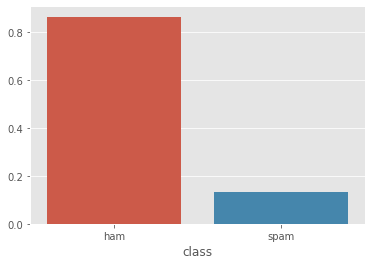

In [ ]:
Util.plot_class_dist(sms._df_raw, 'class')

,number of words
count,5572.000000
mean,16.031407
std,11.832019
min,1.000000
25%,7.000000
50%,13.000000
75%,24.000000
max,175.000000


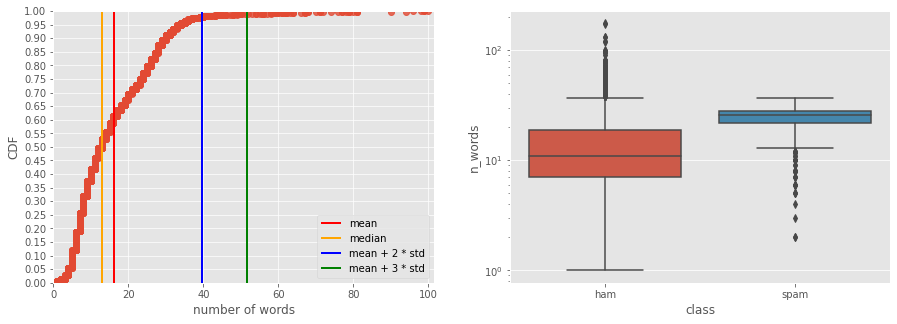

In [ ]:
n_words_in_context = sms._df_raw['n_words'].values.tolist()

figure, axes = plt.subplots(1, 2, figsize=(15,5))
Util.plot_cdf(n_words_in_context, 
         axes[0], 
         xlim=[0, np.mean(n_words_in_context) + 3 * np.std(n_words_in_context) + 50],
         deltay = 0.05,
         ylim=[0, 1.00], xlabel='number of words')

Util.plot_boxplot(sms._df_raw, 'class', 'n_words', axes[1])

,len of context
count,5572.000000
mean,80.811917
std,60.273482
min,2.000000
25%,36.000000
50%,62.000000
75%,123.000000
max,910.000000


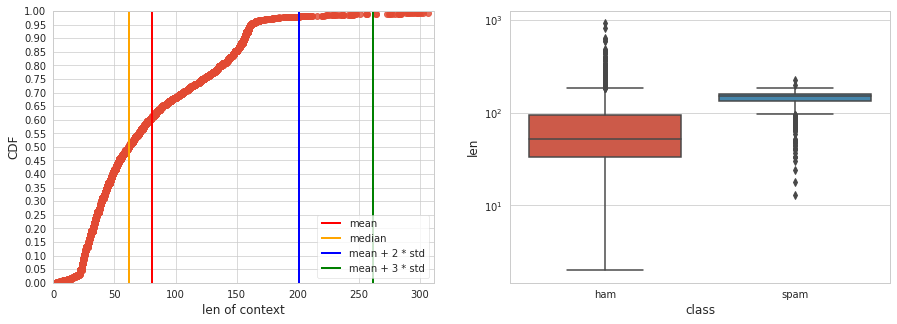

In [ ]:
len_of_context = sms._df_raw['len'].values.tolist()

figure, axes = plt.subplots(1, 2, figsize=(15,5))

Util.plot_cdf(len_of_context, 
         axes[0], 
         xlim=[0, np.mean(len_of_context) + 3 * np.std(len_of_context) + 50],
         deltay = 0.05,
         ylim=[0, 1.00], xlabel='len of context')

Util.plot_boxplot(sms._df_raw, 'class', 'len', axes[1])

In [ ]:

sms._df_raw[sms._df_raw['n_words'] == 1]['context'].values.tolist()

['Yup',
 'Thanx...',
 'Okie...',
 'Ok..',
 'Beerage?',
 'Ok...',
 'Ok...',
 'Ok...',
 'Ok...',
 '645',
 'Ok...',
 'Ok',
 'Ok.',
 'Ok...',
 'Okie...',
 'Yup...',
 'Ok...',
 'Okie',
 'Ok...',
 'Okie',
 'ALRITE',
 'Anything...',
 'Ok',
 'staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323',
 'Ok...',
 ':)',
 'Ok.',
 'Nite...',
 'Ok.',
 'Okie',
 'Ok.',
 'Okie...',
 'G.W.R',
 'Ok',
 'Havent.',
 'Anytime...',
 'Ok...',
 'Okie',
 'Ok',
 'Yup']

In [ ]:

sms._df_raw[sms._df_raw['n_words'] == 16]['context'].values.tolist()

['Even my brother is not like to speak with me. They treat me like aids patent.',
 "I'm back &amp; we're packing the car now , I'll let you know if there's room",
 "K fyi x has a ride early tomorrow morning but he's crashing at our place tonight",
 "Its not the same here. Still looking for a job. How much do Ta's earn there.",
 "I'm still looking for a car to buy. And have not gone 4the driving test yet.",
 'Text her. If she doesnt reply let me know so i can have her log in',
 'Busy here. Trying to finish for new year. I am looking forward to finally meeting you...',
 'Here is your discount code RP176781. To stop further messages reply stop. www.regalportfolio.co.uk. Customer Services 08717205546',
 'Hey so this sat are we going for the intro pilates only? Or the kickboxing too?',
 'From here after The performance award is calculated every two month.not for current one month period..',
 'Hmmm...k...but i want to change the field quickly da:-)i wanna get system administrator or network 

In [ ]:

sms._df_raw[sms._df_raw['len'] == 18]['context'].values.tolist()

['Watching tv lor...',
 'Was the farm open?',
 "Annoying isn't it.",
 'Ok i juz receive..',
 'Okay... We wait ah',
 'At home by the way',
 'Wat r u doing now?',
 "Can... I'm free...",
 'Sorry. || mail? ||',
 'Wat u doing there?',
 'ringtoneking 84484',
 'Wat time ü finish?',
 'Thinking of u ;) x',
 'WHAT TIME U WRKIN?']

In [ ]:
sms._df_raw[sms._df_raw['len'] == 60]['context'].values.tolist()

['Yeah sure , give me a couple minutes to track down my wallet',
 'sorry , no , have got few things to do. may be in pub later.',
 'Today am going to college so am not able to atten the class.',
 'No no:)this is kallis home ground.amla home town is durban:)',
 'I want to show you the world , princess :) how about europe?',
 'Horrible gal. Me in sch doing some stuff. How come u got mc?',
 'Eat jap done oso aft ur lect wat... Ü got lect at 12 rite...',
 'Hai priya are you right. What doctor said pa. Where are you.',
 "Yes , i'm small kid.. And boost is the secret of my energy..",
 'Must come later.. I normally bathe him in da afternoon mah..',
 'Wish u many many returns of the day.. Happy birthday vikky..',
 'Hiya , had a good day? Have you spoken to since the weekend?',
 'Sorry da thangam , very very sorry i am held up with prasad.',
 'I want to be there so i can kiss you and feel you next to me',
 'Yar lor... Keep raining non stop... Or u wan 2 go elsewhere?',
 'Thank u. IT BETTER WORK

In [ ]:
classifiers = ['NB', 'SVM', 'RFT']

In [ ]:
for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time sms.validate(c)

'----------------------------------------NB----------------------------------------'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


scores=[0.9573991  0.95067265 0.93497758 0.94170404 0.96188341 0.9529148
 0.9573991  0.93946188 0.94606742 0.93707865]
mean=0.9479558623469542 std=0.008976897499691616
CPU times: user 49 s, sys: 2.77 s, total: 51.8 s
Wall time: 6min 59s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.0min finished


'----------------------------------------SVM----------------------------------------'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


scores=[0.98878924 0.97533632 0.97533632 0.98654709 0.98430493 0.97982063
 0.97982063 0.97533632 0.96853933 0.97752809]
mean=0.9791358895550966 std=0.005778857969420191
CPU times: user 48.7 s, sys: 3.15 s, total: 51.9 s
Wall time: 7min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.0min finished


'----------------------------------------RFT----------------------------------------'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


scores=[0.97309417 0.96412556 0.95515695 0.96412556 0.96412556 0.95964126
 0.96188341 0.9573991  0.96404494 0.96179775]
mean=0.962539426613594 std=0.004599134407755044
CPU times: user 49.3 s, sys: 3.11 s, total: 52.5 s
Wall time: 7min 16s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.3min finished


In [ ]:
models = {}

for c in classifiers:
    display('-' * 40 + c + '-' * 40)
    %time models[c] = sms.train(c)

In [ ]:
import gensim, logging

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import models

class SMSDL(SMSBase):
    
    # To implement a processing chain, some global variables were used.
    __clean_tokens = None
    __clean_corpus = None
    __word2vec = None
    __tokenizer = None
    __x_train_token_padded_seqs = None  # pad_sequences
    __x_test_token_padded_seqs = None  # pad_sequences
    __embedding_matrix = None
    __nn_layers = None
    
    # To create word2vec, the parameters are used in Gensim, below.
    # There are a few different approaching like the below instead of creating our word2vec model,
    # + Google's pre-trained vectors based on GoogleNews
    # + GLoVe's pre-trained vectors based on Wikipages
    # + Spacy pre-trained vectors
    __embedding_dim = 300
    __window = 15
    __workers = 4
    __cbow_mean = 1
    __alpha = 0.05
    
    # Creating file names for models with respect to given parameters, above.
    __format_word2vec_model = 'emb_dim:{}_window:{}_cbow:{}_apha:{}.bin'
    __word2vec_file = __format_word2vec_model.format(__embedding_dim, __window, __cbow_mean, __alpha)

    # Creating an embedding matrix using by word2vec model and the parameters, below
    __embedding_vector_length = 300
    __max_nb_words = 200000
    __max_input_length = 50

    # Deep Learning Layers' parameters are using to build a deep network. Our network consists of the layers, below:
    # + Embedding Layer
    # + Dense Layer
    # + LSTM for RNN Layer
    # + Dense Layer
    __num_lstm = 100
    __num_dense = 300
    __rate_drop_out = 0.1
    __rate_drop_lstm = float(0.15 + np.random.rand() * 0.25)
    __rate_drop_dense = float(0.15 + np.random.rand() * 0.25)

    # Creating file names for models with respect to given parameters, above.
    __format_dl_model = 'lstm_%d_%d_%.2f_%.2f.h5'
    __model_dl_file = __format_dl_model % (__num_lstm, __num_dense, __rate_drop_lstm, __rate_drop_dense)

    # In training step, those parameters are using, below.
    __number_of_epochs = 100
    __batch_size = 2048
    __validation_split = 0.1
    __shuffle = True
    
    def __init__(self, filename, frac=0.8):
        super().__init__(filename, frac)
        
        self.__x_name = 'context'
        self.__y_name = 'class'
        
        self.__label_classes = {'ham':0, 'spam':1}
        self.__num_classes = len(self.__label_classes)
        self.__encode_labels()
        
        self.__split_sentence_by_lemmas()
        self.__split_sentence_by_tokens()
            

    def __split_sentence_by_lemmas(self):
        self.__sentences_by_lemmas = list(map(lambda c : self.create_lemmas(c), self._df_raw[self.__x_name].values.tolist()))

    def __split_sentence_by_tokens(self):
        self.__sentences_by_tokens = list(map(lambda c : self.create_tokens(c), self._df_raw[self.__x_name].values.tolist()))

    def __encode_labels(self):
        # https://keras.io/utils/#to_categorical
        encoded_list = list(map(lambda c : self.__label_classes[c], self._df_train[self.__y_name].values.tolist()))
        self.__y_train_one_hot = to_categorical(encoded_list, self.__num_classes)
        
    def __create_word2vec(self, by='lemmas'):
        
        if not os.path.exists(self.__word2vec_file) or self.__word2vec is None:
            if by is 'lemmas':
                sentences = self.__sentences_by_lemmas
            elif by is 'tokens':
                sentences = self.__sentences_by_tokens
            else:
                print('You picked wrong function. Please, check your parameter you are using')
                return
            
            logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
            
            print('{} doesn\'t exist. A new word2vec is being built...'.format(self.__word2vec_file))
            
            self.__word2vec = gensim.models.Word2Vec(sentences,
                                                    size=self.__embedding_dim,
                                                    window=self.__window,
                                                    workers=self.__workers,
                                                    cbow_mean=self.__cbow_mean,
                                                    alpha=self.__alpha)
            self.__word2vec.save(self.__word2vec_file)

        elif self.__word2vec is not None:
            print('{} has already loaded for word2vec...'.format(self.__word2vec_file))
        else:
            print('{} is loading for word2vec...'.format(self.__word2vec_file))
            self.__word2vec = gensim.models.Word2Vec.load(self.__word2vec_file)
        
    def __create_tokenizer(self):
        
        self.__x_train_corpus = self._df_train[self.__x_name].values.tolist() 
        self.__x_test_corpus = self._df_test[self.__x_name].values.tolist()
        
        all_corpus = self.__x_train_corpus + self.__x_test_corpus

        print('x_train_corpus: {}'.format(len(self.__x_train_corpus)))
        print('x_test_corpus: {}'.format(len(self.__x_test_corpus)))

        # https://keras.io/preprocessing/text/#tokenizer
        self.__tokenizer = Tokenizer(num_words=self.__max_nb_words)
        self.__tokenizer.fit_on_texts(all_corpus)

        print('Found %s unique tokens' % len(self.__tokenizer.word_index))


    def __create_sequences(self):

        # https://keras.io/preprocessing/text/#text_to_word_sequence
        x_train_token_seqs = self.__tokenizer.texts_to_sequences(self.__x_train_corpus)
        x_test_token_seqs = self.__tokenizer.texts_to_sequences(self.__x_test_corpus)

        print('x_train_token_seqs: {}'.format(len(x_train_token_seqs)))
        print('x_test_token_seqs: {}'.format(len(x_test_token_seqs)))
        
        # https://keras.io/preprocessing/sequence/#pad_sequences
        self.__x_train_token_padded_seqs = pad_sequences(x_train_token_seqs, maxlen=self.__max_input_length)
        self.__x_test_token_padded_seqs = pad_sequences(x_test_token_seqs, maxlen=self.__max_input_length)
        print('x_train_token_padded_seqs: {}'.format(self.__x_train_token_padded_seqs.shape))
        print('x_test_token_padded_seqs: {}'.format(self.__x_test_token_padded_seqs.shape))

    def __create_embedding_matrix(self):
        
        token_index = self.__tokenizer.word_index
        self.__number_words = min(self.__max_nb_words, len(token_index)) + 1
        
        self.__embedding_matrix = np.zeros((self.__number_words, self.__embedding_vector_length))
        for word, i in token_index.items():
            if word in self.__word2vec.wv.vocab:
                self.__embedding_matrix[i] = self.__word2vec.wv.word_vec(word)

        print('Null word embeddings: %d' % np.sum(np.sum(self.__embedding_matrix, axis=1) == 0))
        print('embedding_matrix: {}'.format(self.__embedding_matrix.shape))
        
    def __init_weights(self, shape, dtype=None):
        print('init_weights shape: {}'.format(shape))
        # assert  shape == embedding_matrix.shape
        return self.__embedding_matrix

    def __create_embedding_layer(self):
        
        # https://keras.io/layers/embeddings/
        embedding = Embedding(self.__number_words,
                                self.__embedding_vector_length,
                                input_length=self.__max_input_length,
                                mask_zero=True,
                                embeddings_initializer=self.__init_weights)
        
        return embedding

    
    def __create_nn_layers(self, weights_filename=None):

        if self.__nn_layers is None:

            self.__nn_layers = Sequential()
            self.__nn_layers.add(self.__create_embedding_layer())

            # https://keras.io/layers/core/#dense
            # https://keras.io/layers/core/#activation
            self.__nn_layers.add(Dense(self.__num_dense, activation='sigmoid'))
            self.__nn_layers.add(Dropout(self.__rate_drop_out))

            # https://keras.io/layers/recurrent/
            self.__nn_layers.add(LSTM(self.__num_lstm, 
                               dropout=self.__rate_drop_lstm, 
                               recurrent_dropout=self.__rate_drop_lstm))
            
            self.__nn_layers.add(Dense(self.__num_classes, activation='softmax'))

            # https://keras.io/metrics/
            self.__nn_layers.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
            
            self.__nn_layers.summary()
        
        if weights_filename is not None:
            self.__nn_layers.load_weights(weights_filename)

    def __build_model(self, weights_filename=None):

        self.__create_word2vec()
        self.__create_tokenizer()
        self.__create_sequences()
        self.__create_embedding_matrix()
        self.__create_nn_layers(weights_filename)

    def __create_callbacks(self, tensorboard):

        callbacks = []
        # https://keras.io/callbacks/#usage-of-callbacks
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

        print(self.__model_dl_file)
        # https://keras.io/callbacks/#modelcheckpoint
        model_checkpoint = ModelCheckpoint(self.__model_dl_file, save_best_only=True)

        # https://keras.io/callbacks/#tensorboard
        if tensorboard:
            tensor_board = TensorBoard(log_dir='./logs',
                                       histogram_freq=5,
                                       write_graph=True,
                                       write_images=True,
                                       embeddings_freq=0,
                                       embeddings_layer_names=None,
                                       embeddings_metadata=None)
            callbacks.append(tensor_board)

        callbacks.append(early_stopping)
        callbacks.append(model_checkpoint)

        return callbacks
    
    def load_model(self, filename):
        model = models.load_model(filename)
        return model

    def train(self, tensorboard_enable=False):

        self.__build_model()

        callbacks = self.__create_callbacks(tensorboard_enable)

        # https://keras.io/models/model/
        self._model = self.__nn_layers.fit(self.__x_train_token_padded_seqs,
                             self.__y_train_one_hot,
                             epochs=self.__number_of_epochs,
                             batch_size=self.__batch_size,
                             validation_split=self.__validation_split,
                             shuffle=self.__shuffle,
                             callbacks=callbacks)

        best_val_score = max(self._model.history['val_accuracy'])
        print('Best Score by val_acc: {}'.format(best_val_score))
        
        self.__df_history = pd.DataFrame()
        self.__df_history['accuracy'] = self._model.history['accuracy']
        self.__df_history['loss'] = self._model.history['loss']
        self.__df_history['val_accuracy'] = self._model.history['val_accuracy']
        self.__df_history['val_loss'] = self._model.history['val_loss']
        
    
    def __test(self, X_token_padded_seqs):
        prediction_probs = self.__nn_layers.predict(X_token_padded_seqs,
                                             batch_size=self.__batch_size,
                                             verbose=1)

        pre_label_ids = list(map(lambda probs: probs.argmax(), list(prediction_probs)))
        classes = ['ham', 'spam']
    
        return list(map(lambda x: classes[x], pre_label_ids))        
    
            
    def test(self, X_token_padded_seqs=None, weights_filename=None):
        self.__build_model(weights_filename=weights_filename)
        
        if X_token_padded_seqs is None:
            return self.__test(self.__x_test_token_padded_seqs)
        else:
            return self.__test(X_token_padded_seqs)
        
    def __test2(self, X_token_padded_seqs, model):
        prediction_probs = model.predict(X_token_padded_seqs,
                                             batch_size=self.__batch_size,
                                             verbose=1)

        pre_label_ids = list(map(lambda probs: probs.argmax(), list(prediction_probs)))
        classes = ['ham', 'spam']

        return list(map(lambda x: classes[x], pre_label_ids))  
    
    def report_cm2(self, model):        
        X_train = self.__x_train_token_padded_seqs
        X_test = self.__x_test_token_padded_seqs
        
        y_train = self._df_train[self.__y_name].values.tolist()
        y_test = self._df_test[self.__y_name].values.tolist()
        
        y_train_pred = self.__test2(self.__x_train_token_padded_seqs, model)
        y_test_pred = self.__test2(self.__x_test_token_padded_seqs, model)
        
        classes = ['ham', 'spam']
        
        Util.report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)
    
    def report_cm(self, weights_filename):
        self.__build_model(weights_filename)
        
        X_train = self.__x_train_token_padded_seqs
        X_test = self.__x_test_token_padded_seqs
        
        y_train = self._df_train[self.__y_name].values.tolist()
        y_test = self._df_test[self.__y_name].values.tolist()
        
        y_train_pred = self.__test(self.__x_train_token_padded_seqs)
        y_test_pred = self.__test(self.__x_test_token_padded_seqs)
        
        classes = ['ham', 'spam']
        
        Util.report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)

    def display_history(self):
        display(self.__df_history.describe())
        
    def plot_acc(self):
        self.__df_history[['acc', 'val_acc']].plot()
        
    def plot_loss(self):
        self.__df_history[['loss', 'val_loss']].plot()

In [ ]:
sms_dl = SMSDL('SMS')

,freq of unique words
count,9009.000000
mean,9.834832
std,62.019317
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,2361.000000


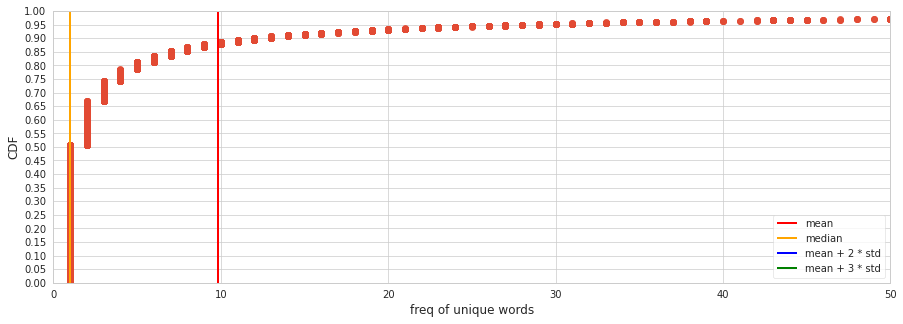

In [ ]:
tokenizer = sms_dl._SMSDL__tokenizer
freq_of_unique_words = list(map(lambda x : x[1], tokenizer.word_counts.items()))

figure, axes = plt.subplots(1, figsize=(15,5))
Util.plot_cdf(freq_of_unique_words, 
              axes,
              xlim = [0, 50],
              deltay = 0.05,
              ylim = [0, 1.00], xlabel='freq of unique words')

In [ ]:
sim = {}
sample_words = ['phone', 'sms', 'bank', 
                'call', 'discount', 'off', 
                'award', 'winner', 'free', 
                'text', 'cash', 'money', 
                'credit', 'prize', 'insurance', 
                'sale', 'click', 
                '%', '$', 'pound']

for w in sample_words:
    sim[w] = sms_dl._SMSDL__word2vec.most_similar(w)

pd.DataFrame(sim).applymap(lambda x: '{} : {:.2f}'.format(x[0], float(x[1]))).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()


,0,1,2,3,4,5,6,7,8,9
phone,CHAT : 0.93,please : 0.92,deliver : 0.92,message : 0.91,announcement : 0.91,Should : 0.90,meal : 0.90,arrive : 0.90,service : 0.89,number : 0.89
sms,apply : 0.98,password : 0.98,partner : 0.97,> : 0.97,www : 0.97,sp : 0.97,info : 0.97,18 : 0.97,T&C : 0.97,weekly : 0.97
bank,allow : 0.99,add : 0.99,blood : 0.98,listen : 0.98,g : 0.98,hopefully : 0.98,south : 0.98,nigeria : 0.98,interested : 0.98,mr : 0.98
call,customer : 0.97,service : 0.96,please : 0.96,mobile : 0.95,4.50 : 0.94,December : 0.94,claim : 0.94,350 : 0.93,pc : 0.93,reward : 0.92
discount,SavaMob : 1.00,150 : 1.00,age16 : 1.00,85023 : 1.00,weekly : 1.00,chance : 0.99,Cost : 0.99,comp : 0.99,TONE : 0.99,HMV : 0.99
off,bed : 0.99,lol : 0.99,midnight : 0.99,freak : 0.99,pop : 0.99,alright : 0.98,mo : 0.98,actually : 0.98,die : 0.98,pub : 0.98
award,£ : 1.00,select : 1.00,350 : 0.99,draw : 0.99,collect : 0.99,claim : 0.99,Bonus : 0.99,receive : 0.99,Prize : 0.98,800 : 0.98
winner,000 : 0.97,select : 0.94,£ : 0.94,cash : 0.94,specially : 0.93,inc : 0.93,collection : 0.93,T&Cs : 0.93,await : 0.93,award : 0.93
free,min : 0.97,per : 0.97,mobile : 0.97,txt : 0.97,16 : 0.96,tone : 0.96,Holder : 0.96,pc : 0.96,rcvd : 0.96,text : 0.96
text,pc : 0.96,free : 0.96,service : 0.95,week : 0.94,mobile : 0.93,4.50 : 0.93,25 : 0.92,December : 0.92,pic : 0.92,rcvd : 0.92


In [ ]:
sms_dl.train()

2021-06-17 10:41:52,229 : INFO : collecting all words and their counts
2021-06-17 10:41:52,232 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-17 10:41:52,265 : INFO : collected 9678 word types from a corpus of 104757 raw words and 5572 sentences
2021-06-17 10:41:52,270 : INFO : Loading a fresh vocabulary
2021-06-17 10:41:52,284 : INFO : effective_min_count=5 retains 1765 unique words (18% of original 9678, drops 7913)
2021-06-17 10:41:52,286 : INFO : effective_min_count=5 leaves 92873 word corpus (88% of original 104757, drops 11884)
2021-06-17 10:41:52,299 : INFO : deleting the raw counts dictionary of 9678 items
2021-06-17 10:41:52,304 : INFO : sample=0.001 downsamples 64 most-common words
2021-06-17 10:41:52,306 : INFO : downsampling leaves estimated 60664 word corpus (65.3% of prior 92873)
2021-06-17 10:41:52,317 : INFO : estimated required memory for 1765 words and 300 dimensions: 5118500 bytes
2021-06-17 10:41:52,322 : INFO : resetting layer we

emb_dim:300_window:15_cbow:1_apha:0.05.bin doesn't exist. A new word2vec is being built...


2021-06-17 10:41:52,703 : INFO : training model with 4 workers on 1765 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=15
2021-06-17 10:41:52,882 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-17 10:41:52,895 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-17 10:41:52,896 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-17 10:41:52,905 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-17 10:41:52,908 : INFO : EPOCH - 1 : training on 104757 raw words (60677 effective words) took 0.2s, 315093 effective words/s
2021-06-17 10:41:53,094 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-17 10:41:53,098 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-17 10:41:53,106 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-17 10:41:53,108 : INFO : worker thread finished; awaiting finish of 0 m

x_train_corpus: 4458
x_test_corpus: 1114
Found 9009 unique tokens
x_train_token_seqs: 4458
x_test_token_seqs: 1114
x_train_token_padded_seqs: (4458, 50)
x_test_token_padded_seqs: (1114, 50)
Null word embeddings: 7563
embedding_matrix: (9010, 300)
init_weights shape: (9010, 300)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 300)           2703000   
_________________________________________________________________
dense_12 (Dense)             (None, 50, 300)           90300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_13 (Dense)             (None, 2) 

In [ ]:
sms_dl.display_history()

,accuracy,loss,val_accuracy,val_loss
count,41.000000,41.000000,41.000000,41.000000
mean,0.942745,0.146517,0.941321,0.164882
std,0.090882,0.162258,0.045375,0.118584
min,0.487039,0.016205,0.869955,0.074572
25%,0.870140,0.026399,0.872197,0.078841
50%,0.988534,0.052934,0.968610,0.092039
75%,0.993769,0.232522,0.973094,0.253956
max,0.996760,0.668959,0.977578,0.423061


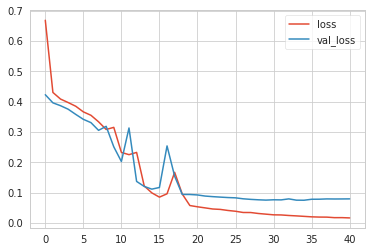

In [ ]:

sms_dl.plot_loss()

emb_dim:300_window:15_cbow:1_apha:0.05.bin has already loaded for word2vec...
x_train_corpus: 4458
x_test_corpus: 1114
Found 9009 unique tokens
x_train_token_seqs: 4458
x_test_token_seqs: 1114
x_train_token_padded_seqs: (4458, 50)
x_test_token_padded_seqs: (1114, 50)
Null word embeddings: 7563
embedding_matrix: (9010, 300)
1/1 [==============================] - 1s 728ms/step
--------------------Testing Performance--------------------
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       968
        spam       0.94      0.93      0.93       146

    accuracy                           0.98      1114
   macro avg       0.96      0.96      0.96      1114
weighted avg       0.98      0.98      0.98      1114

acc:  0.9829443447037702
--------------------Training Performance--------------------
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3857
        spam       0.98      0.97      0

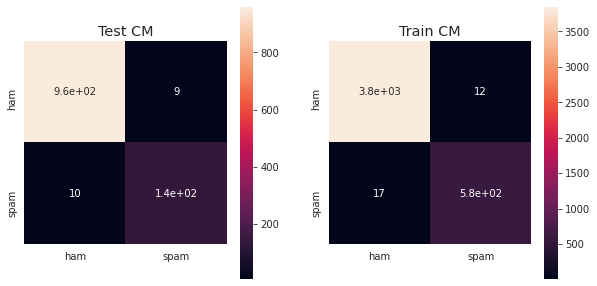

In [ ]:
sms_dl.report_cm('lstm_100_300_0.25_0.29.h5')

# New Section